# Recommender Systems

The two most common types of recommender systems are <b>content-based</b> and <b>collaborative filtering</b>.
* Content-based recommender systems focus on the <b>attributes of items</b> and gives you recommendations based on the <b>similarity</b> between them. (Similar to this...)
* Collaborative filtering produces recommendations based on the <b>knowledge of users' attitudes to items</b>, that is it uses the wisdom of the crowd to recommend items. (Users also liked this...)
     
     * Collaborative filtering is more commonly used because it gives better results and is relatively easier to understand. The algorithm has the ability to do feature learning on its own.
     * CF can be further divided into <b>memory-based collaborative filtering</b> (using singular value decomposition) and <b>model-based collaborative filtering</b> (using cosine similarity).

## Get data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np 
import pandas as pd

In [3]:
# MovieLens dataset
column_names = ['user_id','item_id','rating','timestamp']
df = pd.read_csv('files/u.data', sep='\t', names=column_names)
df.head() # movies are listed by ID, we'll want to merge with movie names

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [4]:
df.info() #100,003 entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100003 non-null  int64
 1   item_id    100003 non-null  int64
 2   rating     100003 non-null  int64
 3   timestamp  100003 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [5]:
df.describe() # no NaN

,user_id,item_id,rating,timestamp
count,100003.000000,100003.000000,100003.000000,1.000030e+05
mean,462.470876,425.520914,3.529864,8.835288e+08
std,266.622454,330.797791,1.125704,5.343791e+06
min,0.000000,1.000000,1.000000,8.747247e+08
25%,254.000000,175.000000,3.000000,8.794487e+08
50%,447.000000,322.000000,4.000000,8.828269e+08
75%,682.000000,631.000000,4.000000,8.882600e+08
max,943.000000,1682.000000,5.000000,8.932866e+08


In [6]:
names = pd.read_csv('files/Movie_Id_Titles')
names.head() # Each movie title is linked to its id 

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
df = pd.merge(df,names,on='item_id')
df.head() # now have the title for each movie rating

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


## Some EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

### Highest and lowest rated movies

In [9]:
df.groupby(by='title')['rating'].mean().sort_values(ascending=False)

title
Marlene Dietrich: Shadow and Light (1996)       5.0
Prefontaine (1997)                              5.0
Santa with Muscles (1996)                       5.0
Star Kid (1997)                                 5.0
Someone Else's America (1995)                   5.0
                                               ... 
Touki Bouki (Journey of the Hyena) (1973)       1.0
JLG/JLG - autoportrait de décembre (1994)       1.0
Daens (1992)                                    1.0
Butterfly Kiss (1995)                           1.0
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
Name: rating, Length: 1664, dtype: float64

### Most and least rated movies

In [10]:
df.groupby(by='title')['rating'].count().sort_values(ascending=False)

title
Star Wars (1977)                              584
Contact (1997)                                509
Fargo (1996)                                  508
Return of the Jedi (1983)                     507
Liar Liar (1997)                              485
                                             ... 
Man from Down Under, The (1943)                 1
Marlene Dietrich: Shadow and Light (1996)       1
Mat' i syn (1997)                               1
Mille bolle blu (1993)                          1
Á köldum klaka (Cold Fever) (1994)              1
Name: rating, Length: 1664, dtype: int64

### Create a ratings dataframe

In [11]:
ratings = pd.DataFrame(df.groupby(by='title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [12]:
ratings['raters'] = df.groupby(by='title')['rating'].count()
ratings.head()

,rating,raters
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


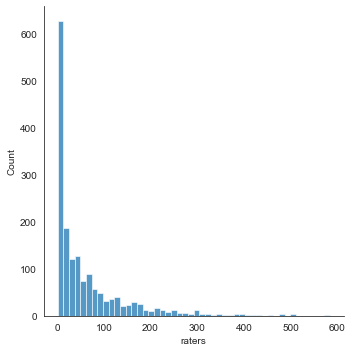

In [13]:
# Most movies have very few raters, right skewed
sns.displot(data=ratings,x='raters')

<AxesSubplot:xlabel='rating', ylabel='Count'>

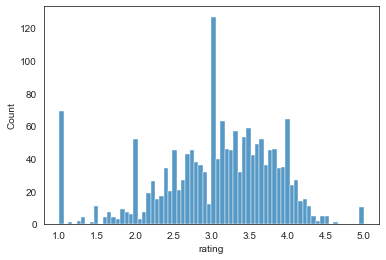

In [14]:
# Peaks at whole numbers, somewhat normal
sns.histplot(data=ratings,x='rating',bins=70)

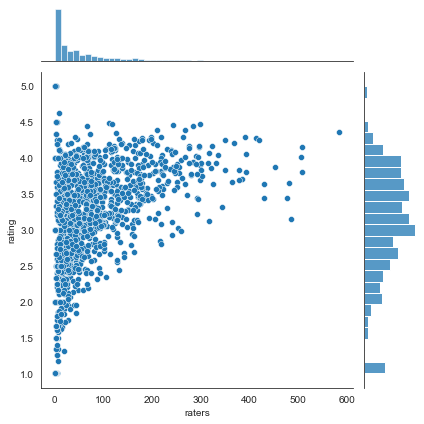

In [15]:
# Trend: Higher rating for movies with more viewers 
# But some outliers who got 5 stars from just a few watchers
sns.jointplot(x='raters',y='rating',data=ratings)

## Compare movie ratings
### Create a matrix of movie ratings

In [16]:
# Rating scores by user for each movie
matrix = df.pivot_table(index='user_id',columns='title',values='rating')
matrix # Lots of NaN, most users haven't seen most movies

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Select movies to compare

In [17]:
# Get top 10 rated movies
ratings['raters'].sort_values(ascending=False).head(10)

title
Star Wars (1977)                 584
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: raters, dtype: int64

In [18]:
# Choose Star Wars and Toy Story
sw_ratings = matrix['Star Wars (1977)']
tt_ratings = matrix['Toy Story (1995)']

### Get correlations for each movie

In [19]:
sw_corr = matrix.corrwith(sw_ratings)
sw_corr = pd.DataFrame(sw_corr,columns=['Correlation to Star Wars'])
sw_corr.dropna(inplace=True)
sw_corr.head() # Returns the correlation between star wars movie ratings and other movies

,Correlation to Star Wars
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [20]:
tt_corr = matrix.corrwith(tt_ratings)
tt_corr = pd.DataFrame(tt_corr,columns=['Correlation to Toy Story'])
tt_corr.dropna(inplace=True)
tt_corr.head() # Returns the correlation between toy story movie ratings and other movies

,Correlation to Toy Story
title,
'Til There Was You (1997),0.534522
101 Dalmatians (1996),0.232118
12 Angry Men (1957),0.334943
187 (1997),0.651857
2 Days in the Valley (1996),0.162728


### Problem --> Some bad correlations

In [21]:
# Correlations with random movies due to only 1 or few watchers rating both movies identically
sw_corr.sort_values('Correlation to Star Wars',ascending=False).head()

,Correlation to Star Wars
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0


In [22]:
# Correlations with random movies due to only 1 or few watchers rating both movies identically
tt_corr.sort_values('Correlation to Toy Story',ascending=False).head()

,Correlation to Toy Story
title,
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0
Reckless (1995),1.0
Ladybird Ladybird (1994),1.0
Infinity (1996),1.0
Albino Alligator (1996),1.0


### Solution --> Add a minimum threshold for the number of ratings

#### Step 1 - Add the number of raters to the correlation dataframes

In [23]:
sw_corr = sw_corr.join(ratings['raters'])
sw_corr.head()

,Correlation to Star Wars,raters
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [24]:
tt_corr = tt_corr.join(ratings['raters'])
tt_corr.head()

,Correlation to Toy Story,raters
title,,
'Til There Was You (1997),0.534522,9
101 Dalmatians (1996),0.232118,109
12 Angry Men (1957),0.334943,125
187 (1997),0.651857,41
2 Days in the Valley (1996),0.162728,93


#### Step 2 - Filter out all the movies with less than 100 raters

In [25]:
sw_corr = sw_corr[sw_corr['raters'] > 100]
sw_corr.head()

,Correlation to Star Wars,raters
title,,
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
2001: A Space Odyssey (1968),0.230884,259
Absolute Power (1997),0.085440,127
"Abyss, The (1989)",0.203709,151


In [26]:
tt_corr = tt_corr[tt_corr['raters'] > 100]
tt_corr.head()

,Correlation to Toy Story,raters
title,,
101 Dalmatians (1996),0.232118,109
12 Angry Men (1957),0.334943,125
2001: A Space Odyssey (1968),-0.069060,259
Absolute Power (1997),0.318580,127
"Abyss, The (1989)",0.329058,151


#### Step 3 - Check correlations now

In [27]:
# More sensical correlations 
sw_corr.sort_values('Correlation to Star Wars',ascending=False).head(10)

,Correlation to Star Wars,raters
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [28]:
# More sensical correlations now
tt_corr.sort_values('Correlation to Toy Story',ascending=False).head(10)

,Correlation to Toy Story,raters
title,,
Toy Story (1995),1.000000,452
"Craft, The (1996)",0.549100,104
Down Periscope (1996),0.457995,101
Miracle on 34th Street (1994),0.456291,101
G.I. Jane (1997),0.454756,175
Amistad (1997),0.449915,124
Beauty and the Beast (1991),0.442960,202
"Mask, The (1994)",0.432855,129
Cinderella (1950),0.428372,129


## Make full blown recommendation System for all movies

In [29]:
# Dictionary containing all movie correlation dataframe
dfs = {}

# For every movie 
for col in matrix:
    # Get the correlations
    corr = matrix.corrwith(matrix[col])
    # Make a dataframe
    corr = pd.DataFrame(corr, columns=[f'Correlation to {col}'])
    # Add number of ratings
    corr = corr.join(ratings['raters'])
    #Drop null values
    corr.dropna(inplace=True)
    # Tier the movies by viewership to avoid bad correlations
    if ratings.loc[col]['raters'] > 100: # blockbuster greater than 100 ratings
        corr = corr[corr['raters'] > 100]
    elif ratings.loc[col]['raters'] > 50: # somewhat popular movies 
        corr = corr[corr['raters'] > 20]
    else:  # unpopular movies 
        corr = corr[corr['raters'] > 5]
    # Add it to the repository of movies
    dfs[col] = corr

In [32]:
# Example of one movie's dataframe
dfs['101 Dalmatians (1996)']

,Correlation to 101 Dalmatians (1996),raters
title,,
101 Dalmatians (1996),1.000000,109
12 Angry Men (1957),-0.049890,125
2001: A Space Odyssey (1968),-0.043407,259
Absolute Power (1997),0.398783,127
"Abyss, The (1989)",0.236350,151
...,...,...
Willy Wonka and the Chocolate Factory (1971),0.105261,326
"Wizard of Oz, The (1939)",0.366592,246
"Wrong Trousers, The (1993)",-0.002382,118


In [33]:
# You can now recommend the most similar movies for every movie in the repository

# Example of top tier movie
dfs['Raiders of the Lost Ark (1981)'].sort_values('Correlation to Raiders of the Lost Ark (1981)',ascending=False).head(10)

,Correlation to Raiders of the Lost Ark (1981),raters
title,,
Raiders of the Lost Ark (1981),1.000000,420
Indiana Jones and the Last Crusade (1989),0.539606,331
"Empire Strikes Back, The (1980)",0.538659,368
Star Wars (1977),0.536117,584
Back to the Future (1985),0.506807,350
"Firm, The (1993)",0.490823,151
Return of the Jedi (1983),0.467391,507
Braveheart (1995),0.458854,297
Field of Dreams (1989),0.424938,212


In [51]:
# Example of mid tier movie
dfs['Addams Family Values (1993)'].sort_values('Correlation to Addams Family Values (1993)',ascending=False).head(10)

,Correlation to Addams Family Values (1993),raters
title,,
Addams Family Values (1993),1.000000,87
Soul Food (1997),1.000000,59
Oscar & Lucinda (1997),1.000000,21
Mad City (1997),1.000000,47
"Portrait of a Lady, The (1996)",1.000000,25
Paths of Glory (1957),0.970725,33
Spice World (1997),0.970725,26
Richie Rich (1994),0.942928,21
"Crossing Guard, The (1995)",0.942809,28


In [60]:
# Example of low tier movie (here will get bad corrleations to other low viewership films)
dfs['Spy Hard (1996)'].sort_values('Correlation to Spy Hard (1996)',ascending=False).head(10)

,Correlation to Spy Hard (1996),raters
title,,
Oliver & Company (1988),1.0,22
Spy Hard (1996),1.0,43
Unzipped (1995),1.0,11
"Cowboy Way, The (1994)",1.0,19
"Cry, the Beloved Country (1995)",1.0,24
Some Kind of Wonderful (1987),1.0,59
Something to Talk About (1995),1.0,26
Great Expectations (1998),1.0,27
Andre (1994),1.0,18
